# Toy Example

In [1]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import torch

### Using autograd

100%|██████████| 100/100 [00:00<00:00, 1581.80it/s]

optimised x: 1.1364996861264146e-29


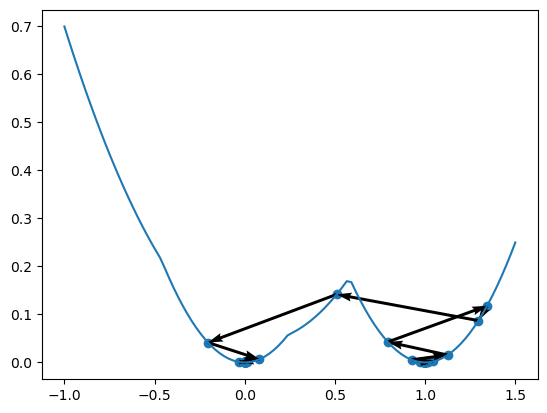

In [28]:
class ToyExample:
    def __init__(self, as_, lr, iters, k, func_type):
        self.as_ = as_
        self.lr = lr
        self.iters = iters
        self.k = k
        
        self.rng = np.random.default_rng()
        if func_type=='quad':
            self.func = self.quad_func
        elif func_type=='quad_duo':
            self.func = self.quad_duo_func
            if len(as_.shape)!=2:
                raise ValueError('as_ should have 2 dimensional shape')


    def rand_init_x(self, range=(-10, 10)):
        x = torch.distributions.uniform.Uniform(range[0], range[1]).sample()
        x.requires_grad_(True)
        return x
    
    def expectation_a(self):
        return self.as_.sum()/len(self.as_)
    
    def quad_func(self, x, stochastic = True):    
        if stochastic:
            a_ = self.rng.choice(self.as_, size=1)[0]
        else:
            a_ = self.expectation_a()

        y = x*x*a_/self.k
        return y
    
    def quadDuo_subFunc(self, sub_as_, x):
        f1 = sub_as_[0]*(x**2)/self.k
        f2 = sub_as_[1]*((x-1)**2)/self.k

        if f1<f2:
            return f1, sub_as_[0]
        else:
            return f2, sub_as_[1]
    
    def quad_duo_func(self, x, stochastic = True):
        if stochastic:
            c = self.rng.choice([0, 1], size=1)[0]
            y, a_ = self.quadDuo_subFunc(self.as_[c], x)
        else:
            y1, a1 = self.quadDuo_subFunc(self.as_[0], x)
            y2, a2 = self.quadDuo_subFunc(self.as_[1], x)
            y = (y1 + y2)/2

        return y
        
    
    def optimize(self, x, stochastic = True):
        self.x_prog = [x.item()]
        self.f_prog = [self.func(x, False).item()]
        self.dynamics_rv_prog = []
        self.grad_prog = []
        

        for _ in tqdm(range(self.iters)):
            y = self.func(x, stochastic=stochastic)
            y.backward()

            with torch.no_grad():
                # print(x.grad == x*a_)
                x.copy_(x - self.lr*x.grad)

                # dynamics_rv realization
                dynamics_rv = 1 - (self.lr*x.grad.item()/(x.item() + 1e-10))
                self.dynamics_rv_prog.append(dynamics_rv)
                self.grad_prog.append(x.grad.item())
                x.grad.zero_()

            self.x_prog.append(x.item())
            self.f_prog.append(self.func(x, False).item())

        return x.item()
    
    def plot(self):
        # x_ax = np.linspace(-10, 10, 100)
        x_ax = np.linspace(-1, 1.5, 100)

        y_ax = np.array([self.func(x, stochastic=False) for x in x_ax])
        plt.plot(x_ax, y_ax)
        plt.scatter(self.x_prog, self.f_prog)

        diff_x = np.diff(self.x_prog)
        diff_f = np.diff(self.f_prog)
        plt.quiver(self.x_prog[:-1], self.f_prog[:-1], diff_x, diff_f, angles = 'xy', scale_units='xy', scale=1)
        plt.show()


lr = 0.7
iters = 100
k = 1


# as_ = np.array([0.1, 1.9])
# as_ = np.array([1, 1])
as_ = np.array([[1, 0.1], [1, 1.9]])

# toy = ToyExample(as_, lr, iters, k, 'quad')
# x_opt = toy.optimize(toy.rand_init_x())

toy = ToyExample(as_, lr, iters, k, 'quad_duo')
x_opt = toy.optimize(toy.rand_init_x(range=(1-(1e-3), 1+(1e-3))))


print('optimised x:', x_opt)
toy.plot()


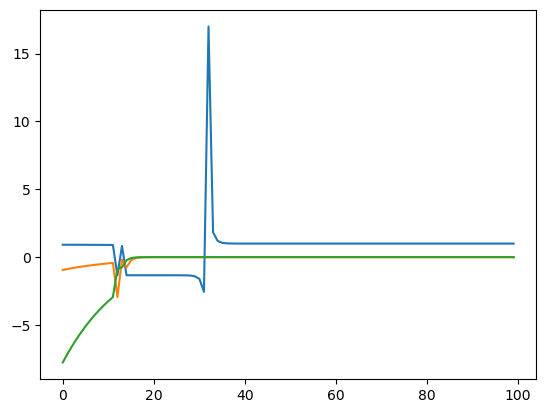

In [19]:
plt.plot(toy.dynamics_rv_prog)
plt.plot(toy.grad_prog)
plt.plot(toy.x_prog[1:])

In [25]:
1-np.array(toy.grad_prog)/(np.array(toy.x_prog[1:])+1e-10)

array([ 0.87861322,  0.877424  ,  0.876119  ,  0.87468439,  0.87310428,
        0.87136015,  0.86943045,  0.86728985,  0.86490842,  0.8622505 ,
        0.85927331,  0.85592503, -2.33333297,  0.74926369, -2.33333307,
       -2.33333334, -2.33333298, -2.33333318, -2.33333352, -2.33333408,
       -2.33333501, -2.3333401 , -2.3333554 , -2.33340852, -2.33358385,
       -2.33416863, -2.33612006, -2.34264112, -2.36456254, -2.43975793,
       -2.71663706, -4.07954263, 23.84518812,  2.18215943,  1.28411527,
        1.08043547,  1.02372981,  1.00708364,  1.00212194,  1.0006363 ,
        1.00019086,  1.00005726,  1.00001718,  1.00000515,  1.00000155,
        1.00000046,  1.00000014,  1.00000004,  1.00000001,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

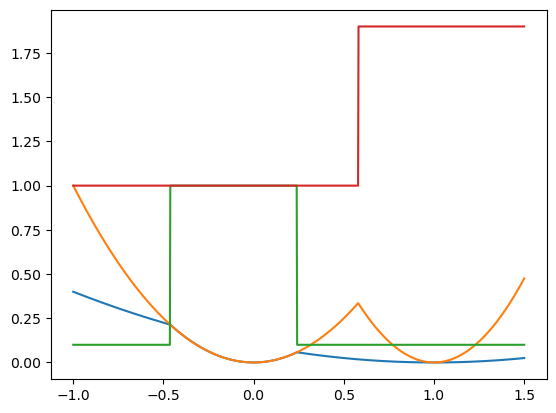

In [73]:
x_ax = np.linspace(-1, 1.5, 1000)
f1_ax = [quadDuo_subFunc(as_[0], x)[0].item() for x in x_ax]
f2_ax = [quadDuo_subFunc(as_[1], x)[0].item() for x in x_ax]

a_1 = [quadDuo_subFunc(as_[0], x)[1] for x in x_ax]
a_2 = [quadDuo_subFunc(as_[1], x)[1] for x in x_ax]


plt.plot(x_ax, f1_ax)
plt.plot(x_ax, f2_ax)
plt.plot(x_ax, a_1)
plt.plot(x_ax, a_2)


tensor(-7.3786, requires_grad=True)


100%|██████████| 100/100 [00:00<00:00, 2699.85it/s]


np.float64(1.7475999999999994)

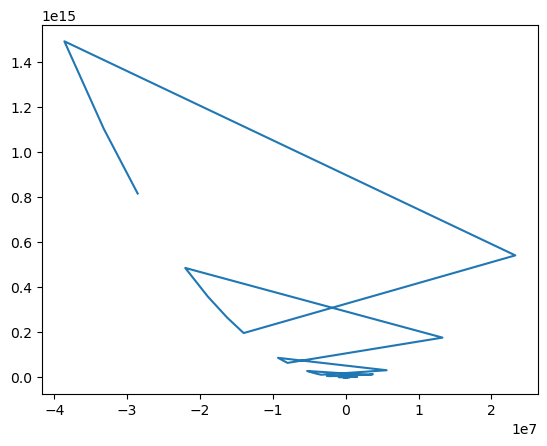

In [ ]:

rng = np.random.default_rng()


def expectation_a_square(as_):
    return np.square(as_).sum()/len(as_)

def var_a(as_):
    '''this is nothing but s^2'''
    return expectation_a_square(as_) - expectation_a(as_)**2

def calc_dynamic_value(a_, lr, k):
    return 1 - (2*lr*a_/k)

def func(x, as_, k = 2, stochastic=True):    
    if stochastic:
        a_ = rng.choice(as_, size=1)[0]
    else:
        a_ = expectation_a(as_)

    y = x*x*a_/k
    return y



x = torch.distributions.uniform.Uniform(-10, 10).sample()
x.requires_grad_(True)

print(x)


dynamics_rv = np.array([calc_dynamic_value(a_, lr, k) for a_ in as_])
dynamics_rv_square = np.square(dynamics_rv)

x_prog = [x.item()]
f_prog = [func(x, as_, k, stochastic=False).item()]

for _ in tqdm(range(iters)):
    y = func(x, as_, k, stochastic=True)
    y.backward()

    with torch.no_grad():
        # print(x.grad == x*a_)
        x.copy_(x-lr*x.grad)
        x.grad.zero_()

    x_prog.append(x.item())
    f_prog.append(func(x, as_, k, stochastic=False).item())



x_prog = np.array(x_prog)
f_prog = np.array(f_prog)

plt.plot(x_prog, f_prog)


dynamics_rv_square.mean()